# Pretraining

**Import required dependencies**

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import model_from_json

from google.colab import files

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
print(tf.version.VERSION)

2.14.0


**Download Flick30k dataset from drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/training/30k_img_cap_model_014_heads_16.keras '/content/gdrive/My Drive/Xavier Kuehn EdLight Take-Home Task/30k_img_cap_model_014_heads_16.keras'

In [ ]:
!cp '/content/gdrive/My Drive/Xavier Kuehn EdLight Take-Home Task/flick30k.zip' /content/flick30k.zip
!unzip flick30k.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/Images/434938585.jpg  
  inflating: __MACOSX/archive/Images/._434938585.jpg  
  inflating: archive/Images/3260088697.jpg  
  inflating: __MACOSX/archive/Images/._3260088697.jpg  
  inflating: archive/Images/4857774876.jpg  
  inflating: __MACOSX/archive/Images/._4857774876.jpg  
  inflating: archive/Images/4410008455.jpg  
  inflating: __MACOSX/archive/Images/._4410008455.jpg  
  inflating: archive/Images/2931392634.jpg  
  inflating: __MACOSX/archive/Images/._2931392634.jpg  
  inflating: archive/Images/3066429707.jpg  
  inflating: __MACOSX/archive/Images/._3066429707.jpg  
  inflating: archive/Images/350426761.jpg  
  inflating: __MACOSX/archive/Images/._350426761.jpg  
  inflating: archive/Images/6141695796.jpg  
  inflating: __MACOSX/archive/Images/._6141695796.jpg  
  inflating: archive/Images/149806768.jpg  
  inflating: __MACOSX/archive/Images/._149806768.jpg  
  inflating: archive/Images/358012011.jpg  
  

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

**Setup constants**

In [ ]:
# Path to the images
IMAGES_PATH = "archive/Images"
# Desired image dimensions
IMAGE_SIZE = (299, 299)
# Vocabulary size
VOCAB_SIZE = 10000
# Fixed length allowed for any sequence
SEQ_LENGTH = 50
# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512
# Per-layer units in the feed-forward network
FF_DIM = 512
# Other training parameters
BATCH_SIZE = 128
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

**Prepare Flickr30k dataset**

In [ ]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
          # remove newline character
          line = line.rstrip('\n')
          # Separate image name and captions using ',' with a maxsplit of 1
          img_name, caption = line.split(',', maxsplit=1)
          # Join the path with the base images directory
          img_name = os.path.join(IMAGES_PATH, img_name.strip())
          # Remove captions that are either too short to too long
          tokens = caption.strip('.').strip(',').split()
          if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
            images_to_skip.add(img_name)
            continue

          if img_name.endswith("jpg") and img_name not in images_to_skip:
            # Add a start and an end token to each caption
            caption = "<start> " + caption.strip() + " <end>"
            text_data.append(caption)

            if img_name in caption_mapping:
              caption_mapping[img_name].append(caption)
            else:
              caption_mapping[img_name] = [caption]

          for img_name in images_to_skip:
            if img_name in caption_mapping:
              del caption_mapping[img_name]

        return caption_mapping, text_data

def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # Get the list of all image names
    all_images = list(caption_data.keys())

    # Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # Return the splits
    return training_data, validation_data

# Load the dataset
captions_mapping, text_data = load_captions_data("archive/captions.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  24480
Number of validation samples:  6120


**Vectorize the data**

In [ ]:
# def custom_standardization(input_string):
#     lowercase = tf.strings.lower(input_string)
#     return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
# strip_chars = strip_chars.replace("<", "")
# strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize='lower',
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

**Build the training data pipeline**

In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

**Build model and its components**

In [ ]:
# get pretrained EfficientNet model
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

# Transformer encoder layer
@keras.saving.register_keras_serializable(package="MyLayers", name="TransformerEncoderBlock")
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def get_config(self):
        base_config = super().get_config()
        config = {
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        }
        return {**base_config, **config}

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

# Transformer potitional encoding layer
@keras.saving.register_keras_serializable(package="MyLayers", name="PositionalEmbedding")
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def get_config(self):
      base_config = super().get_config()
      config = {
        'sequence_length': self.sequence_length,
        'vocab_size': self.vocab_size,
        'embed_dim': self.embed_dim
      }
      return {**base_config, **config}

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# Transformer decoder layer
@keras.saving.register_keras_serializable(package="MyLayers", name="TransformerDecoderBlock")
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def get_config(self):
      base_config = super().get_config()
      config = {
        'embed_dim': self.embed_dim,
        'ff_dim': self.ff_dim,
        'num_heads': self.num_heads,
      }
      return {**base_config, **config}

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

# Image Captioning model implementation
@keras.saving.register_keras_serializable(package="MyModels", name="ImageCaptioningModel")
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def get_config(self):
      base_config = super().get_config()
      config = {
        'cnn_model': keras.saving.serialize_keras_object(self.cnn_model),
        'encoder': keras.saving.serialize_keras_object(self.encoder),
        'decoder': keras.saving.serialize_keras_object(self.decoder)
      }
      return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
      config["cnn_model"] = keras.layers.deserialize(config["cnn_model"])
      config["encoder"] = keras.layers.deserialize(config["encoder"])
      config["decoder"] = keras.layers.deserialize(config["decoder"])
      return cls(**config)

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # Get the gradients
            grads = tape.gradient(loss, train_vars)

            # Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

**Create the model instance**

In [ ]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=8)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=8)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
def create_model():
  cnn_model = get_cnn_model()
  # the number of heads for the transformer blocks may be changed for performance
  encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=16)
  decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=16)
  caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
  )
  return caption_model

caption_model = create_model()

**Configure model options**

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Learning Rate Scheduler for the optimizer
@keras.saving.register_keras_serializable(package="MySchedules", name="LRSchedule")
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, post_warmup_learning_rate, warmup_steps):
    super().__init__()
    self.post_warmup_learning_rate = post_warmup_learning_rate
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    global_step = tf.cast(step, tf.float32)
    warmup_steps = tf.cast(self.warmup_steps, tf.float32)
    warmup_progress = global_step / warmup_steps
    warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
    return tf.cond(
        global_step < warmup_steps,
        lambda: warmup_learning_rate,
        lambda: self.post_warmup_learning_rate,
    )

  def get_config(self):
    config = {
        'post_warmup_learning_rate': self.post_warmup_learning_rate,
        'warmup_steps': self.warmup_steps
    }
    return config

# Create learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Model checkpoint saving callback
if not os.path.exists("/training"):
  os.makedirs("/training")
# Create model checkpoint callback
model_checkpoint = keras.callbacks.ModelCheckpoint('/content/training/30k_img_cap_model_{epoch:03d}_heads_16.keras')

**Model training**

In [ ]:
# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
192/192 [==============================] - ETA: 0s - loss: 25.4999 - acc: 0.1910

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


192/192 [==============================] - 403s 2s/step - loss: 25.4999 - acc: 0.1915 - val_loss: 18.0458 - val_acc: 0.3757
Epoch 2/50
192/192 [==============================] - 383s 2s/step - loss: 17.1787 - acc: 0.3785 - val_loss: 15.9234 - val_acc: 0.4082
Epoch 3/50
192/192 [==============================] - 383s 2s/step - loss: 15.6575 - acc: 0.4062 - val_loss: 14.9753 - val_acc: 0.4248
Epoch 4/50
192/192 [==============================] - 383s 2s/step - loss: 14.7927 - acc: 0.4215 - val_loss: 14.4841 - val_acc: 0.4331
Epoch 5/50
192/192 [==============================] - 383s 2s/step - loss: 14.2000 - acc: 0.4326 - val_loss: 14.1425 - val_acc: 0.4387
Epoch 6/50
192/192 [==============================] - 383s 2s/step - loss: 13.7310 - acc: 0.4417 - val_loss: 13.8732 - val_acc: 0.4447
Epoch 7/50
192/192 [==============================] - 383s 2s/step - loss: 13.3415 - acc: 0.4496 - val_loss: 13.7514 - val_acc: 0.4448
Epoch 8/50
192/192 [==============================] - 383s 2s/step

**Define testing method**

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption():
    # Select a random image from the validation dataset
    sample_img = valid_images[np.random.choice(len(valid_images))]

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = min(np.argmax(predictions[0, i, :]), len(vocab) - 1)
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

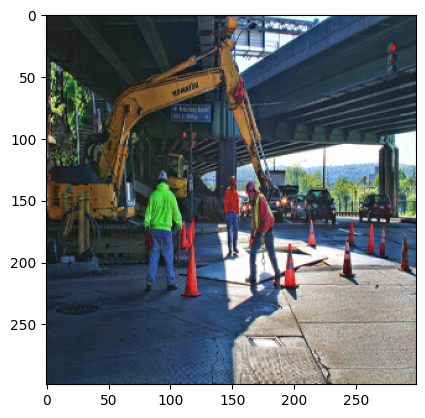

Predicted Caption:  a construction worker is standing on a sidewalk .


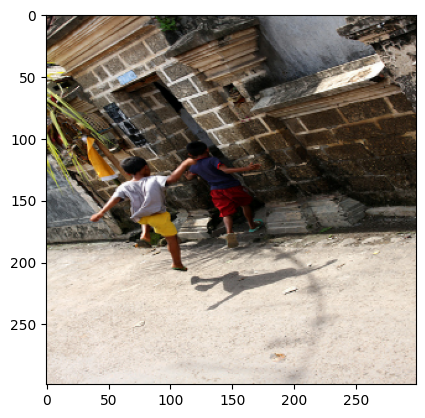

Predicted Caption:  a man in a white shirt and black shorts is walking in front of a stone building .


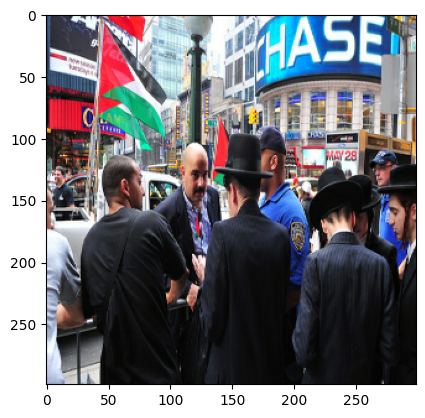

Predicted Caption:  a man in a black hat is standing in front of a store .


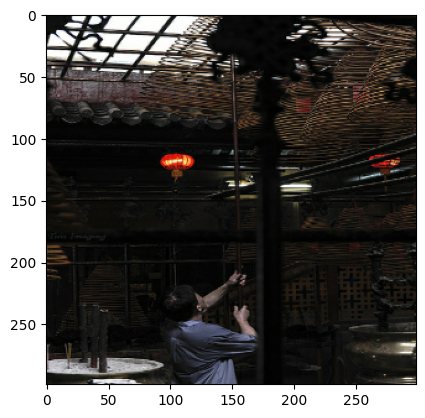

Predicted Caption:  a man in a blue shirt is standing in front of a large building with a large orange balloon .


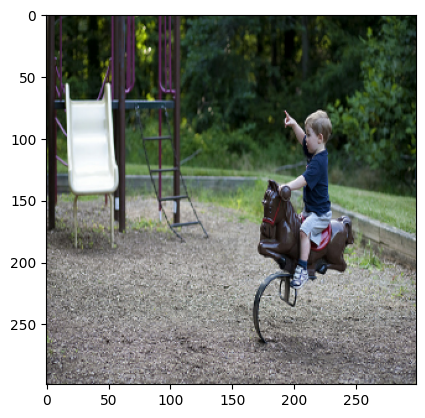

Predicted Caption:  a young boy is riding a bike in a park .


In [ ]:
for _ in range(5):
  generate_caption()

# Fine-Tuning

**Import dependencies**

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import model_from_json

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

**Download EdLight data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip edlight_images.zip
!cp '/content/gdrive/My Drive/Xavier Kuehn EdLight Take-Home Task/descriptions.csv' /content/descriptions.csv

**Setup constants**

In [ ]:
# Path to the images
IMAGES_PATH = 'edlight_images'
# Desired image dimensions
IMAGE_SIZE = (299, 299)
# Vocabulary size
VOCAB_SIZE = 10000
# Fixed length allowed for any sequence
SEQ_LENGTH = 50
# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512
# Per-layer units in the feed-forward network
FF_DIM = 512
# Other training parameters
BATCH_SIZE = 64
EPOCHS = 100
AUTOTUNE = tf.data.AUTOTUNE

**Prepare EdLight dataset**

In [ ]:
def load_captions_data(filename):
  """Loads captions (text) data and maps them to corresponding images.

  Args:
      filename: Path to the text file containing caption data.

  Returns:
      caption_mapping: Dictionary mapping image names and the corresponding captions
      text_data: List containing all the available captions
  """
  # opening the CSV file
  with open(filename, mode ='r') as file:
    # reading the CSV file
    captions_to_images = csv.reader(file)
    caption_mapping = {}
    text_data = []
    images_to_skip = set()

    # displaying the contents of the CSV file
    for pair in captions_to_images:
      if pair == ('description', 'file'):
        continue

      # collect caption and image from pair
      caption = pair[0].rstrip('\n')
      image_name = os.path.join(IMAGES_PATH, pair[1])

      # omit captions that are too long or too short
      tokens = caption.strip().split()
      if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
        images_to_skip.add(image_name)
        continue

      # append <start> and <end> token to each caption
      if image_name.endswith("jpg") and image_name not in images_to_skip and not os.path.exists(image_name):
        images_to_skip.add(image_name)
        continue
      else:
        caption = "<start> " + caption.strip() + " <end>"
        text_data.append(caption)

        if image_name in caption_mapping:
          caption_mapping[image_name].append(caption)
        else:
          caption_mapping[image_name] = [caption]

    for img_name in images_to_skip:
      if img_name in caption_mapping:
        del caption_mapping[img_name]

    return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.80, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # Get the list of all image names
    all_images = list(caption_data.keys())

    # Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # Return the splits
    return training_data, validation_data

# Load the dataset
captions_mapping, text_data = load_captions_data('/content/gdrive/MyDrive/EdLight Take-Home Task/descriptions.csv')

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  3069
Number of validation samples:  768


**Vectorize the data**

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize='lower',
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

**Build the training dataset pipeline**

In [ ]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

**Build model and its components**

In [ ]:
# get pretrained EfficientNet model
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model

# Transformer encoder layer
@keras.saving.register_keras_serializable(package="MyLayers", name="TransformerEncoderBlock")
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def get_config(self):
        base_config = super().get_config()
        config = {
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        }
        return {**base_config, **config}

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

# Transformer potitional encoding layer
@keras.saving.register_keras_serializable(package="MyLayers", name="PositionalEmbedding")
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def get_config(self):
      base_config = super().get_config()
      config = {
        'sequence_length': self.sequence_length,
        'vocab_size': self.vocab_size,
        'embed_dim': self.embed_dim
      }
      return {**base_config, **config}

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# Transformer decoder layer
@keras.saving.register_keras_serializable(package="MyLayers", name="TransformerDecoderBlock")
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def get_config(self):
      base_config = super().get_config()
      config = {
        'embed_dim': self.embed_dim,
        'ff_dim': self.ff_dim,
        'num_heads': self.num_heads,
      }
      return {**base_config, **config}

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

# Image Captioning model implementation
@keras.saving.register_keras_serializable(package="MyModels", name="ImageCaptioningModel")
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def get_config(self):
      base_config = super().get_config()
      config = {
        'cnn_model': keras.saving.serialize_keras_object(self.cnn_model),
        'encoder': keras.saving.serialize_keras_object(self.encoder),
        'decoder': keras.saving.serialize_keras_object(self.decoder)
      }
      return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
      config["cnn_model"] = keras.layers.deserialize(config["cnn_model"])
      config["encoder"] = keras.layers.deserialize(config["encoder"])
      config["decoder"] = keras.layers.deserialize(config["decoder"])
      return cls(**config)

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # Get the gradients
            grads = tape.gradient(loss, train_vars)

            # Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

**Create model instance**

In [ ]:
def create_model():
  cnn_model = get_cnn_model()
  # the number of heads for the transformer blocks may be changed for performance
  encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
  decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=4)
  caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, num_captions_per_image=1, image_aug=image_augmentation
  )
  return caption_model

edlight_model = create_model()

**Configure model options**

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Learning Rate Scheduler for the optimizer
@keras.saving.register_keras_serializable(package="MySchedules", name="LRSchedule")
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, post_warmup_learning_rate, warmup_steps):
    super().__init__()
    self.post_warmup_learning_rate = post_warmup_learning_rate
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    global_step = tf.cast(step, tf.float32)
    warmup_steps = tf.cast(self.warmup_steps, tf.float32)
    warmup_progress = global_step / warmup_steps
    warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
    return tf.cond(
        global_step < warmup_steps,
        lambda: warmup_learning_rate,
        lambda: self.post_warmup_learning_rate,
    )

  def get_config(self):
    config = {
        'post_warmup_learning_rate': self.post_warmup_learning_rate,
        'warmup_steps': self.warmup_steps
    }
    return config

# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Model checkpoint saving callback
if not os.path.exists("/training"):
  os.makedirs("/training")

# Create model checkpoint callback
model_checkpoint = keras.callbacks.ModelCheckpoint('/training/img_cap_edlight_{epoch:03d}.keras')

**Model training**

In [ ]:
def train_model(model):
  # Compile the model
  model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

  # Fit the model
  model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, model_checkpoint]
  )
  return model

**Define testing method**

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = edlight_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = edlight_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = edlight_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = min(np.argmax(predictions[0, i, :]), len(vocab) - 1)
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

**Train ImageCaptioningModel only on EdLight dataset to benchmark performance**

In [ ]:
# Compile the model
edlight_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
edlight_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, model_checkpoint]
  )

**Generate captions for different models**

In [ ]:
# set desired model name here
model_name = ''
edlight_model.load_weights('/training/{model_name}.keras'.format(model_name=model_name))
generate_caption()